In [1]:
import matplotlib.pyplot as plt
import numpy as np

from teyssier import riemann
from superfv.euler_solver import EulerSolver
import superfv.initial_conditions as ic
import superfv.visualization as vis
from superfv.tools.norms import l1_norm

In [2]:
N = 100
CFL = 0.8

sim0 = EulerSolver(
    ic=ic.sod_shock_tube_1d,
    bcx="free",
    riemann_solver="hllc",
    CFL=CFL,
    nx=N,
    p=0,
    flux_recipe=2,
)

sim1 = EulerSolver(
    ic=ic.sod_shock_tube_1d,
    bcx="free",
    riemann_solver="hllc",
    CFL=CFL,
    nx=N,
    p=1,
    flux_recipe=2,
    MUSCL=True,
    MUSCL_limiter="moncen",
)

sim = EulerSolver(
    ic=ic.sod_shock_tube_1d,
    bcx="free",
    riemann_solver="hllc",
    CFL=CFL,
    nx=N,
    p=2,
    flux_recipe=2,
    limiting_vars=("rho",),
    MOOD=True,
    cascade="first-order",
    max_MOOD_iters=1,
    NAD=True,
    NAD_rtol=0.0,
    NAD_atol=1e-14,
    PAD={"rho": (1e-14, None), "P": (1e-14, None)},
)

In [3]:
sim0.euler(0.245)
sim1.musclhancock(0.245)
sim.ssprk3(0.245)

Step #66 @ t=2.45e-01 | dt=8.99e-04 | min(rho)=1.25e-01, min(P)=1.00e-01 | (done)                   
Step #67 @ t=2.45e-01 | dt=3.02e-03 | min(rho)=1.25e-01, min(P)=1.00e-01 | (done)                   
Step #67 @ t=2.45e-01 | dt=1.56e-03 | min(rho)=1.25e-01, min(P)=1.00e-01 | (done)                   


In [15]:
sim.print_timings(total_time_spec=".2f")

Routine                      # of calls  Total time (s) % time
---------------------------  ----------  --------------  ------
wall                                  1            0.37   100.0
take_step                            67            0.36    96.6
compute_dt                           67            0.01     1.6
apply_bc                           1411            0.02     6.6
riemann_solver                      402            0.14    36.4
zhang_shu_limiter                     0               -       -
MOOD_loop                           201            0.19    50.7
      detect_troubled_cells         201            0.06    17.0
      revise_fluxes                 201            0.12    33.2
snapshot                              2            0.01       -
minisnapshot                         68            0.00       -


In [5]:
# analytical solution for error
xana = (np.arange(N) + 0.5) / N
wana = np.zeros([3, N])
for i in range(0, np.size(xana)):
    s = (xana[i] - 0.5) / sim.t
    d, v, p = riemann.exact_solution(s, [1, 0, 1], [0.125, 0, 0.1])
    wana[:, i] = [d, v, p]
rho_ana = wana[0, :]

err0 = l1_norm(sim0.snapshots[-1]["u"][0, :, 0, 0] - rho_ana)
err1 = l1_norm(sim1.snapshots[-1]["u"][0, :, 0, 0] - rho_ana)
err = l1_norm(sim.snapshots[-1]["u"][0, :, 0, 0] - rho_ana)

print(f"sim0 L1 error: {err0:.6e}")
print(f"sim1 L1 error: {err1:.6e}")
print(f"sim L1 error: {err:.6e}")

sim0 L1 error: 1.887168e-02
sim1 L1 error: 5.405104e-03
sim L1 error: 8.023366e-03


In [6]:
# analytical solution for plotting
xana = (np.arange(1024) + 0.5) / 1024
wana = np.zeros([3, 1024])
for i in range(0, np.size(xana)):
    s = (xana[i] - 0.5) / sim.t
    d, v, p = riemann.exact_solution(s, [1, 0, 1], [0.125, 0, 0.1])
    wana[:, i] = [d, v, p]

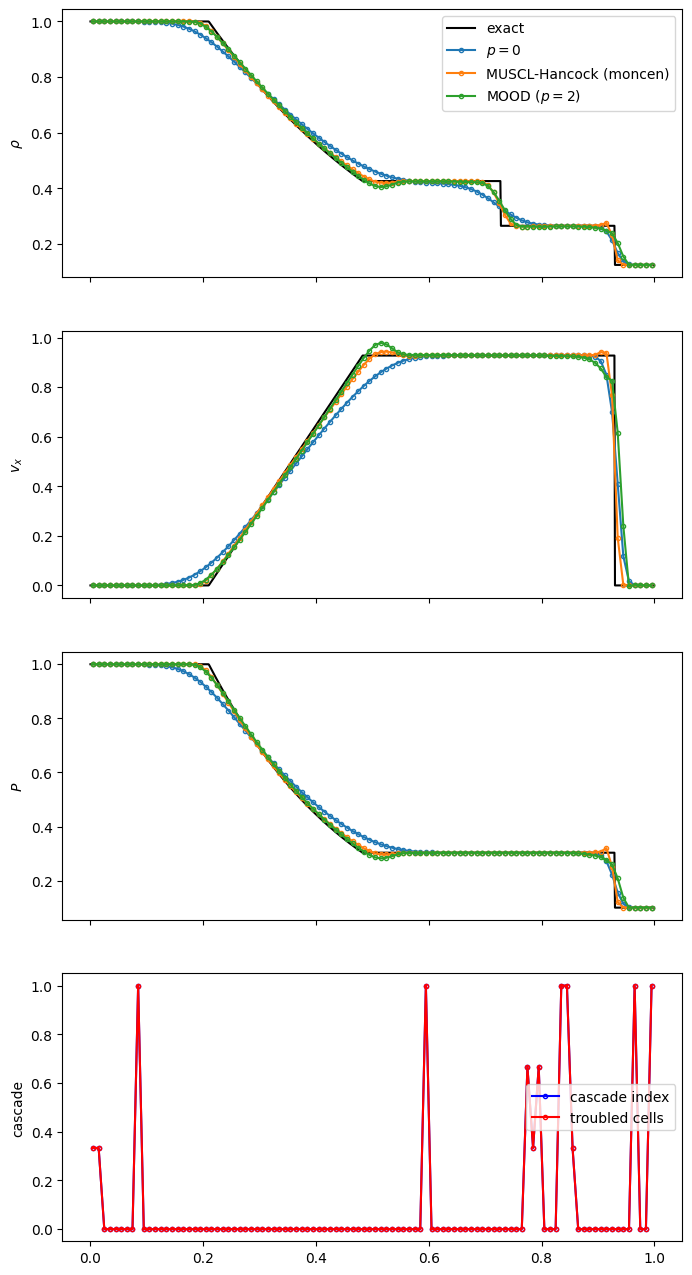

In [7]:
fig, axs = plt.subplots(4, 1, sharex=True, sharey="row", figsize=(8, 16))

axs[0].set_ylabel(r"$\rho$")
axs[1].set_ylabel(r"$v_x$")
axs[2].set_ylabel(r"$P$")
axs[3].set_ylabel("cascade")

style = dict(marker=".", mfc="none", linestyle="-")

axs[0].plot(xana, wana[0], color="k", label="exact")
vis.plot_1d_slice(sim0, axs[0], "rho", **style, label=r"$p=0$")
vis.plot_1d_slice(
    sim1,
    axs[0],
    "rho",
    **style,
    label=f"MUSCL-Hancock ({sim1.base_scheme.limiter_config.limiter})",
)
vis.plot_1d_slice(sim, axs[0], "rho", **style, label=rf"MOOD ($p={sim.p}$)")

axs[1].plot(xana, wana[1], color="k", label="exact")
vis.plot_1d_slice(sim0, axs[1], "vx", **style)
vis.plot_1d_slice(sim1, axs[1], "vx", **style)
vis.plot_1d_slice(sim, axs[1], "vx", **style)

axs[2].plot(xana, wana[2], color="k", label="exact")
vis.plot_1d_slice(sim0, axs[2], "P", **style)
vis.plot_1d_slice(sim1, axs[2], "P", **style)
vis.plot_1d_slice(sim, axs[2], "P", **style)

vis.plot_1d_slice(sim, axs[3], "cascade", color="b", **style, label="cascade index")
vis.plot_1d_slice(sim, axs[3], "troubles", color="r", **style, label="troubled cells")

axs[0].legend()
axs[3].legend()

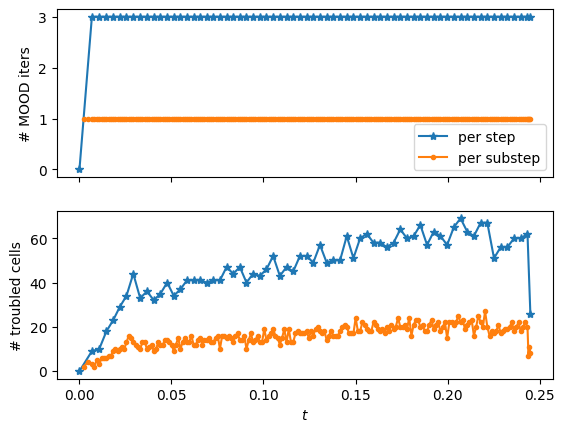

In [8]:
fig, axs = plt.subplots(2, 1, sharex=True)

axs[1].set_xlabel(r"$t$")
axs[0].set_ylabel("# MOOD iters")
axs[1].set_ylabel("# troubled cells")

vis.plot_timeseries(sim, axs[0], "n_MOOD_iters", label="per step", marker="*")
vis.plot_timeseries(sim, axs[0], "nfine_MOOD_iters", label="per substep", marker=".")

vis.plot_timeseries(sim, axs[1], "n_troubled_cells", marker="*")
vis.plot_timeseries(sim, axs[1], "nfine_troubled_cells", marker=".")

axs[0].legend()